# VacationPy
----

#### Note
* Keep an eye on your API usage. Use https://developers.google.com/maps/reporting/gmp-reporting as reference for how to monitor your usage and billing.

* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import json
import os

# Import API key
from api_keys import g_key

# Save image on notebook
from IPython.display import Image

### Store Part I results into DataFrame
* Load the csv exported in Part I to a DataFrame

In [2]:
file_path = "../WeatherPy/cities.csv"
cities_weather_df = pd.read_csv(file_path)
# cities_weather_df
del cities_weather_df["Unnamed: 0"]
cities_weather_df

City  Cloudiness Country          Date  Humidity      Lat  \
0           mataura       100.0      NZ  1.620709e+09      89.0 -46.1927   
1             onega       100.0      RU  1.620709e+09      89.0  63.9061   
2            hasaki        75.0      JP  1.620709e+09      59.0  35.7333   
3             bluff       100.0      NZ  1.620709e+09      89.0 -46.6000   
4             salta        90.0      AR  1.620709e+09     100.0 -24.7859   
..              ...         ...     ...           ...       ...      ...   
561  peachtree city        90.0      US  1.620710e+09     100.0  33.3968   
562      safakulevo         4.0      RU  1.620710e+09      30.0  54.9901   
563       wattegama        40.0      LK  1.620710e+09      74.0   6.7989   
564    buenaventura        87.0      CO  1.620710e+09      79.0   3.8801   
565         rumford       100.0      US  1.620710e+09      70.0  44.5537   

          Lng  Max Temp  Wind Speed  
0    168.8643     46.00       11.01  
1     38.1404     49.15        8.63  
2    140.8333     66.00        6.91  
3    168.3333     46.00       11.01  
4    -65.4117     51.80        3.44  
..        ...       ...         ...  
561  -84.5958     64.99        3.71  
562   62.5442     62.80        4.38  
563   81.4808     87.80        4.61  
564  -77.0312     64.00        2.01  
565  -70.5509     50.00        3.42  

[566 rows x 9 columns]

### Humidity Heatmap
* Configure gmaps.
* Use the Lat and Lng as locations and Humidity as the weight.
* Add Heatmap layer to map.

In [3]:
gmaps.configure(g_key)

In [4]:
locations = cities_weather_df[["Lat", "Lng"]]
humidity = cities_weather_df["Humidity"].astype(float)
max_humidity = max(humidity)

In [5]:
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=humidity, 
                                 dissipating=False, max_intensity=max_humidity, 
                                 point_radius=3.5)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

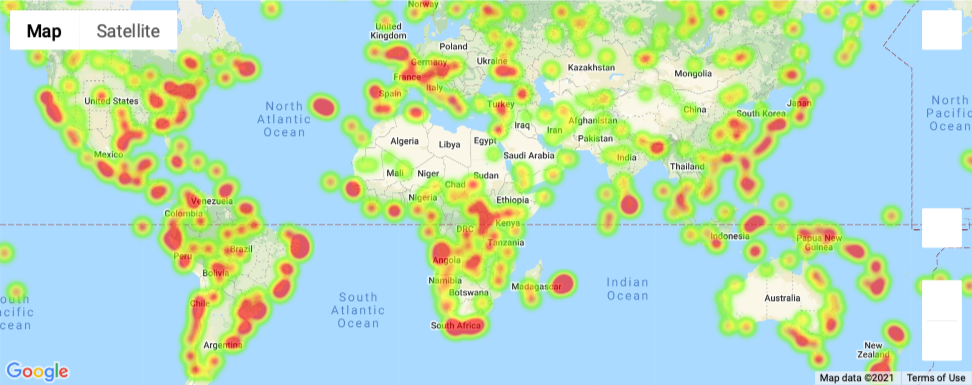

In [6]:
Image("humidity_heatmap.png")

### Create new DataFrame fitting weather criteria
* Narrow down the cities to fit weather conditions.
* Drop any rows will null values.

In [7]:
# Perfect temperature (Between 70 and 80 Degrees)
perfect_conditions = cities_weather_df[(cities_weather_df["Max Temp"] >70) 
                                       & (cities_weather_df["Max Temp"] < 80) 
                                       & (cities_weather_df["Wind Speed"] < 10) 
                                       & (cities_weather_df["Cloudiness"] == 0)]

perfect_conditions

City  Cloudiness Country          Date  Humidity      Lat  \
5          alhandra         0.0      BR  1.620709e+09      94.0  -7.4386   
168  saint-philippe         0.0      RE  1.620709e+09      47.0 -21.3585   
190        oussouye         0.0      SN  1.620709e+09      88.0  12.4850   
220    saint-joseph         0.0      RE  1.620709e+09      47.0 -21.3667   
238         pahrump         0.0      US  1.620709e+09       9.0  36.2083   
297            fasa         0.0      IR  1.620709e+09      33.0  28.9383   
401          najran         0.0      SA  1.620709e+09      21.0  17.4924   
422          nicoya         0.0      CR  1.620709e+09      78.0  10.1483   
428             gat         0.0      IL  1.620709e+09     100.0  31.6100   
464        cabedelo         0.0      BR  1.620710e+09     100.0  -6.9811   
472    saint-pierre         0.0      RE  1.620710e+09      47.0 -21.3393   
502           altar         0.0      MX  1.620710e+09      22.0  30.7000   
533       changping         0.0      CN  1.620710e+09      40.0  40.2186   
540      walvis bay         0.0     NaN  1.620710e+09      24.0 -22.9575   

          Lng  Max Temp  Wind Speed  
5    -34.9144     73.40        5.75  
168   55.7679     77.00        5.75  
190  -16.5469     71.60        4.61  
220   55.6167     77.00        5.75  
238 -115.9839     72.00        1.01  
297   53.6482     73.40        2.46  
401   44.1277     78.80        3.74  
422  -85.4520     77.00        5.75  
428   34.7642     71.01        1.63  
464  -34.8339     71.60        4.61  
472   55.4781     78.01        5.75  
502 -111.8167     71.29        3.98  
533  116.2197     73.40        8.95  
540   14.5053     73.99        9.22

### Hotel Map
* Store into variable named `hotel_df`.
* Add a "Hotel Name" column to the DataFrame.
* Set parameters to search for hotels with 5000 meters.
* Hit the Google Places API for each city's coordinates.
* Store the first Hotel result into the DataFrame.
* Plot markers on top of the heatmap.

In [8]:
hotel_df = pd.DataFrame(perfect_conditions)
hotel_df["Hotel Name"] = ""
hotel_df

City  Cloudiness Country          Date  Humidity      Lat  \
5          alhandra         0.0      BR  1.620709e+09      94.0  -7.4386   
168  saint-philippe         0.0      RE  1.620709e+09      47.0 -21.3585   
190        oussouye         0.0      SN  1.620709e+09      88.0  12.4850   
220    saint-joseph         0.0      RE  1.620709e+09      47.0 -21.3667   
238         pahrump         0.0      US  1.620709e+09       9.0  36.2083   
297            fasa         0.0      IR  1.620709e+09      33.0  28.9383   
401          najran         0.0      SA  1.620709e+09      21.0  17.4924   
422          nicoya         0.0      CR  1.620709e+09      78.0  10.1483   
428             gat         0.0      IL  1.620709e+09     100.0  31.6100   
464        cabedelo         0.0      BR  1.620710e+09     100.0  -6.9811   
472    saint-pierre         0.0      RE  1.620710e+09      47.0 -21.3393   
502           altar         0.0      MX  1.620710e+09      22.0  30.7000   
533       changping         0.0      CN  1.620710e+09      40.0  40.2186   
540      walvis bay         0.0     NaN  1.620710e+09      24.0 -22.9575   

          Lng  Max Temp  Wind Speed Hotel Name  
5    -34.9144     73.40        5.75             
168   55.7679     77.00        5.75             
190  -16.5469     71.60        4.61             
220   55.6167     77.00        5.75             
238 -115.9839     72.00        1.01             
297   53.6482     73.40        2.46             
401   44.1277     78.80        3.74             
422  -85.4520     77.00        5.75             
428   34.7642     71.01        1.63             
464  -34.8339     71.60        4.61             
472   55.4781     78.01        5.75             
502 -111.8167     71.29        3.98             
533  116.2197     73.40        8.95             
540   14.5053     73.99        9.22

In [9]:
params = {"radius": 5000,
          "types": "hotel",
          "keyword": "hotel",
          "key": g_key}

base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

for index, row in hotel_df.iterrows():
    latitude = row["Lat"]
    longitude = row["Lng"]
    params['location'] = f"{latitude},{longitude}"
    
    city = row["City"]
    
    print(f"Retrieving Hotel Name for City ID {index}: {city}")
    response = requests.get(base_url, params=params)
    data = response.json()
    
#     print(json.dumps(data, indent=4))

    try:
        hotel_df.loc[index, "Hotel Name"] = data["results"][0]["name"]
    except:
        print("Missing field/result... skipping.")
        
    print("-----------------")

Retrieving Hotel Name for City ID 5: alhandra
Missing field/result... skipping.
-----------------
Retrieving Hotel Name for City ID 168: saint-philippe
-----------------
Retrieving Hotel Name for City ID 190: oussouye
-----------------
Retrieving Hotel Name for City ID 220: saint-joseph
-----------------
Retrieving Hotel Name for City ID 238: pahrump
-----------------
Retrieving Hotel Name for City ID 297: fasa
-----------------
Retrieving Hotel Name for City ID 401: najran
Missing field/result... skipping.
-----------------
Retrieving Hotel Name for City ID 422: nicoya
-----------------
Retrieving Hotel Name for City ID 428: gat
-----------------
Retrieving Hotel Name for City ID 464: cabedelo
-----------------
Retrieving Hotel Name for City ID 472: saint-pierre
-----------------
Retrieving Hotel Name for City ID 502: altar
-----------------
Retrieving Hotel Name for City ID 533: changping
-----------------
Retrieving Hotel Name for City ID 540: walvis bay
-----------------


In [10]:
# Checking hotel_df
hotel_df

City  Cloudiness Country          Date  Humidity      Lat  \
5          alhandra         0.0      BR  1.620709e+09      94.0  -7.4386   
168  saint-philippe         0.0      RE  1.620709e+09      47.0 -21.3585   
190        oussouye         0.0      SN  1.620709e+09      88.0  12.4850   
220    saint-joseph         0.0      RE  1.620709e+09      47.0 -21.3667   
238         pahrump         0.0      US  1.620709e+09       9.0  36.2083   
297            fasa         0.0      IR  1.620709e+09      33.0  28.9383   
401          najran         0.0      SA  1.620709e+09      21.0  17.4924   
422          nicoya         0.0      CR  1.620709e+09      78.0  10.1483   
428             gat         0.0      IL  1.620709e+09     100.0  31.6100   
464        cabedelo         0.0      BR  1.620710e+09     100.0  -6.9811   
472    saint-pierre         0.0      RE  1.620710e+09      47.0 -21.3393   
502           altar         0.0      MX  1.620710e+09      22.0  30.7000   
533       changping         0.0      CN  1.620710e+09      40.0  40.2186   
540      walvis bay         0.0     NaN  1.620710e+09      24.0 -22.9575   

          Lng  Max Temp  Wind Speed  \
5    -34.9144     73.40        5.75   
168   55.7679     77.00        5.75   
190  -16.5469     71.60        4.61   
220   55.6167     77.00        5.75   
238 -115.9839     72.00        1.01   
297   53.6482     73.40        2.46   
401   44.1277     78.80        3.74   
422  -85.4520     77.00        5.75   
428   34.7642     71.01        1.63   
464  -34.8339     71.60        4.61   
472   55.4781     78.01        5.75   
502 -111.8167     71.29        3.98   
533  116.2197     73.40        8.95   
540   14.5053     73.99        9.22   

                                            Hotel Name  
5                                                       
168                               Les Embruns Du Baril  
190                                   Campement ALULUM  
220                                Gandalf Safari Camp  
238  Holiday Inn Express & Suites Pahrump, an IHG H...  
297                                   Jahangardi Hotel  
401                                                     
422                                       Hotel Nicoya  
428                                         Desert Gat  
464                                      Hotel Almagre  
472                               Le Battant Des Lames  
502                                    Hotel Altar inn  
533                   Beijing Marriott Hotel Changping  
540    Protea Hotel by Marriott Walvis Bay Pelican Bay

In [11]:
# Drop empty rows in hotel_df
nan_value = float("NaN")
hotel_df.replace("", nan_value, inplace=True)
hotel_df.dropna(inplace=True)
hotel_df

City  Cloudiness Country          Date  Humidity      Lat  \
168  saint-philippe         0.0      RE  1.620709e+09      47.0 -21.3585   
190        oussouye         0.0      SN  1.620709e+09      88.0  12.4850   
220    saint-joseph         0.0      RE  1.620709e+09      47.0 -21.3667   
238         pahrump         0.0      US  1.620709e+09       9.0  36.2083   
297            fasa         0.0      IR  1.620709e+09      33.0  28.9383   
422          nicoya         0.0      CR  1.620709e+09      78.0  10.1483   
428             gat         0.0      IL  1.620709e+09     100.0  31.6100   
464        cabedelo         0.0      BR  1.620710e+09     100.0  -6.9811   
472    saint-pierre         0.0      RE  1.620710e+09      47.0 -21.3393   
502           altar         0.0      MX  1.620710e+09      22.0  30.7000   
533       changping         0.0      CN  1.620710e+09      40.0  40.2186   

          Lng  Max Temp  Wind Speed  \
168   55.7679     77.00        5.75   
190  -16.5469     71.60        4.61   
220   55.6167     77.00        5.75   
238 -115.9839     72.00        1.01   
297   53.6482     73.40        2.46   
422  -85.4520     77.00        5.75   
428   34.7642     71.01        1.63   
464  -34.8339     71.60        4.61   
472   55.4781     78.01        5.75   
502 -111.8167     71.29        3.98   
533  116.2197     73.40        8.95   

                                            Hotel Name  
168                               Les Embruns Du Baril  
190                                   Campement ALULUM  
220                                Gandalf Safari Camp  
238  Holiday Inn Express & Suites Pahrump, an IHG H...  
297                                   Jahangardi Hotel  
422                                       Hotel Nicoya  
428                                         Desert Gat  
464                                      Hotel Almagre  
472                               Le Battant Des Lames  
502                                    Hotel Altar inn  
533                   Beijing Marriott Hotel Changping

In [12]:
# NOTE: Do not change any of the code in this cell

# Using the template add the hotel marks to the heatmap
info_box_template = """
<dl>
<dt>Name</dt><dd>{Hotel Name}</dd>
<dt>City</dt><dd>{City}</dd>
<dt>Country</dt><dd>{Country}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
hotel_info = [info_box_template.format(**row) for index, row in hotel_df.iterrows()]
locations = hotel_df[["Lat", "Lng"]]

In [13]:
# Add marker layer ontop of heat map
hotel_markers = gmaps.marker_layer(locations, info_box_content=hotel_info)
fig.add_layer(hotel_markers)
fig


Figure(layout=FigureLayout(height='420px'))

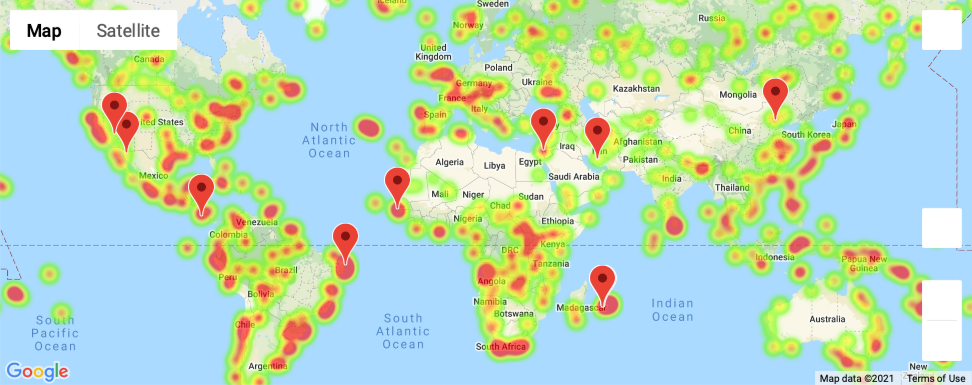

In [17]:
Image("hotel_map.png")